In [ ]:
#|default_exp benchmarking.run_battery
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from fastcore.all import *
import numpy as np
from tqdm.auto import tqdm, trange
from nbdev import show_doc
from diffusion_curvature.utils import plot_3d
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from fastcore.all import *

from scipy.stats import pearsonr

import deepdish
import graphtools
from functools import partial

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 4a Computing the diffusion curvature of the battery

In [ ]:
name = "lowd_highsamples_k5"

In [ ]:
from diffusion_curvature.core import DiffusionCurvature, get_adaptive_graph
def diffusion_curvature_of_pt(X, dim):
    graph_former = partial(
        get_adaptive_graph, k=5,
    )
    G = graph_former(X) #graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1
    )
    ks = DC.curvature(G, t=15, dim=dim, idx=0)
    return ks


In [ ]:
#|export
# from fastprogress.fastprogress import master_bar, progress_bar
# Iterate through the battery and compute the diffusion curvature
# store it in a new dictionary
def compute_curvature_on_battery(
        curvature_function, # fn that, given X and dim, returns the curvature of the first point
        CC, # the battery dictionary
        restrict_to_first_n_dims = None,
        ):
    computed_curvature = {}
    dimensions = CC['dims']
    if restrict_to_first_n_dims:
        dimensions = dimensions[:restrict_to_first_n_dims]
    for d in tqdm(CC['dims'], desc="intrinsic dimensions"):
        computed_curvature[d] = {}
        for c in tqdm(CC[d]['codims'], leave=False, desc='codimensions'):
            computed_curvature[d][c] = {}
            for noise_level in tqdm(CC[d][c]['noise_levels'], leave=False, desc="Noise Levels"):
                computed_curvature[d][c][noise_level] = {}
                computed_curvature[d][c][noise_level]['k'] = []
                # apply curvature function in parallel
                # us = [(CC[d][c][noise_level]['Xs'][i], d) for i in range(len(CC[d][c][noise_level]['Xs']))]
                # ks = parallel(curvature_function, us, n_workers=25)
                # computed_curvature[d][c][noise_level]['k'] = ks
                for i in trange(len(CC[d][c][noise_level]['Xs']), leave=False, desc="Samples"):
                    X = CC[d][c][noise_level]['Xs'][i]
                    k = curvature_function(X, d)
                    computed_curvature[d][c][noise_level]['k'].append(k)
    return computed_curvature

In [ ]:
# load curvature battery
battery_file = "/home/piriac/data/diffusion_curvature/Curvature_Colosseum_LowD_HighSampled.h5"
CC = deepdish.io.load(battery_file)

In [ ]:
saved_calcs = f"/home/piriac/data/diffusion_curvature/computed_diffusion_curvatures_core_{name}.h5"
if os.path.exists(saved_calcs):
    print(f"Loading saved calculations from {saved_calcs}")
    computed_diffusion_curvatures = deepdish.io.load(saved_calcs)
else:
    computed_diffusion_curvatures = compute_curvature_on_battery(diffusion_curvature_of_pt, CC)
    deepdish.io.save(f"/home/piriac/data/diffusion_curvature/computed_diffusion_curvatures_core_{name}.h5", computed_diffusion_curvatures)
computed_curvature = computed_diffusion_curvatures

intrinsic dimensions:   0%|          | 0/2 [00:00<?, ?it/s]

codimensions:   0%|          | 0/1 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/50 [00:00<?, ?it/s]

codimensions:   0%|          | 0/1 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/50 [00:00<?, ?it/s]

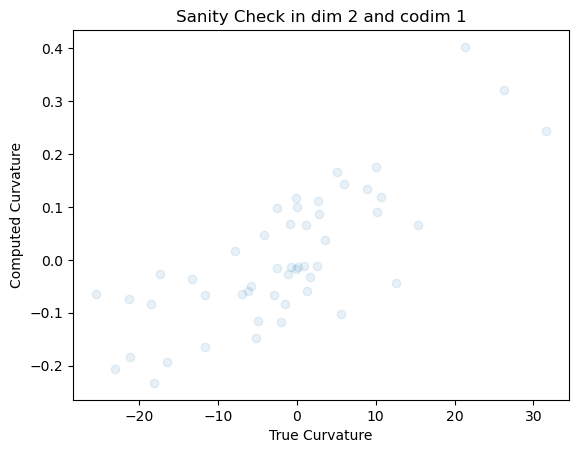

In [ ]:
d = 2
c = 1
noise_level = 0.0
plt.scatter(CC[d][c][noise_level]['k'], computed_curvature[d][c][noise_level]['k'], alpha=0.1)
plt.xlabel("True Curvature")
plt.ylabel("Computed Curvature")
plt.title(f"Sanity Check in dim {d} and codim {c}")
plt.show()

# Pearson Correlations

In [ ]:
#|export
# compute the pearson correlations between the computed curvature and the true curvature
def compute_correlations(
        computed_curvature, # the computed curvature
        CC, # the battery dictionary
        ):
    correlations = {}
    for d in tqdm(CC['dims'], desc="intrinsic dimensions"):
        correlations[d] = {}
        for c in tqdm(CC[d]['codims'], leave=False, desc='codimensions'):
            correlations[d][c] = {}
            for noise_level in tqdm(CC[d][c]['noise_levels'], leave=False, desc="Noise Levels"):
                correlations[d][c][noise_level] = {}
                correlations[d][c][noise_level]['r'] = []
                correlations[d][c][noise_level]['p'] = []
                # for i in trange(len(CC[d][c][noise_level]['Xs']), leave=False, desc="Samples"):
                k = computed_curvature[d][c][noise_level]['k']
                k_true = CC[d][c][noise_level]['k']
                r, p = pearsonr(k, k_true)
                correlations[d][c][noise_level]['r'] = r
                correlations[d][c][noise_level]['p'] = p
    return correlations

In [ ]:
dc_curvature_correlations = compute_correlations(computed_diffusion_curvatures, CC)

intrinsic dimensions:   0%|          | 0/2 [00:00<?, ?it/s]

codimensions:   0%|          | 0/1 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/1 [00:00<?, ?it/s]

codimensions:   0%|          | 0/1 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from tabulate import tabulate

In [ ]:
#|export
# Make a latex table of the correlations, both r and p values, with dimension in the rows and noise level in the columns
def result_table(
        correlations, # dictionary of correlations
        c:int, # codimension
        style = 'fancy_grid',
        keys = ['r','p']
        ):
    noise_levels = correlations[correlations.keys().__iter__().__next__()][c].keys()
    print("Codimension = ",c)
    table = tabulate(
        [[d] + [f"{correlations[d][c][noise_level][keys[0]]:.{3}f}{'/' + str(correlations[d][c][noise_level][keys[1]])[:4] if len(keys) > 1 else ''}" for noise_level in noise_levels] for d in correlations.keys()],
        headers=['dim'] + [f"Noise = {nl}" for nl in noise_levels],
        tablefmt=style, #latex_raw
        floatfmt=".2f",
        )
    print(table)
    return table

In [ ]:
table = result_table(dc_curvature_correlations, c=1)

Codimension =  1
╒═══════╤═══════════════╕
│   dim │ Noise = 0.0   │
╞═══════╪═══════════════╡
│     2 │ 0.780/2.50    │
├───────┼───────────────┤
│     3 │ 0.309/0.02    │
╘═══════╧═══════════════╛


In [ ]:
table_latex = result_table(dc_curvature_correlations, c=1, style='latex_raw')

Codimension =  1
\begin{tabular}{rl}
\hline
   dim & Noise = 0.0   \\
\hline
     2 & 0.780/2.50    \\
     3 & 0.309/0.02    \\
\hline
\end{tabular}


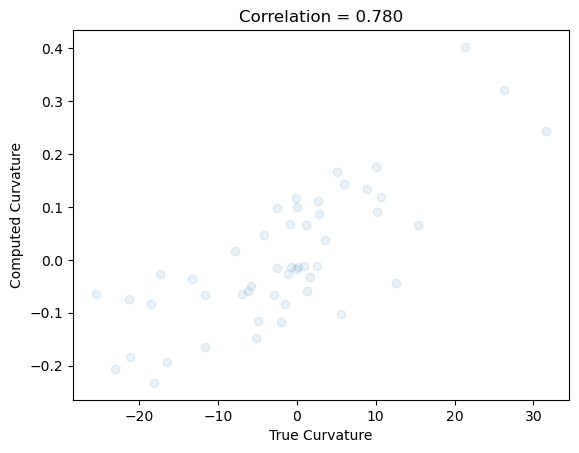

In [ ]:
d = 2
c = 1
noise_level = 0.0
plt.scatter(CC[d][c][noise_level]['k'], computed_diffusion_curvatures[d][c][noise_level]['k'], alpha=0.1)
plt.xlabel("True Curvature")
plt.ylabel("Computed Curvature")
plt.title(f"Correlation = {dc_curvature_correlations[d][c][noise_level]['r']:.3f}")
plt.show()

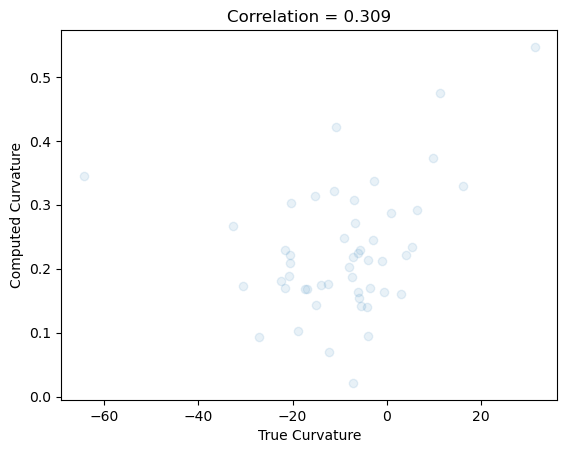

In [ ]:
d = 3
c = 1
noise_level = 0.0
plt.scatter(CC[d][c][noise_level]['k'], computed_diffusion_curvatures[d][c][noise_level]['k'], alpha=0.1)
plt.xlabel("True Curvature")
plt.ylabel("Computed Curvature")
plt.title(f"Correlation = {dc_curvature_correlations[d][c][noise_level]['r']:.3f}")
plt.show()

# Fidelity of Sign

The above shows that the *unsigned* diffusion curvature correlates robustly with the true curvature. Let's measure how well the sign is predicted by diffusion curvature. 

In [ ]:
#|export
def compute_sign_score(
        computed_curvature, # the computed curvature
        CC, # the battery dictionary
        ):
    correlations = {}
    for d in tqdm(CC['dims'], desc="intrinsic dimensions"):
        correlations[d] = {}
        for c in CC[d]['codims']:
            correlations[d][c] = {}
            for noise_level in tqdm(CC[d][c]['noise_levels'], leave=False, desc="Noise Levels"):
                correlations[d][c][noise_level] = {}
                correlations[d][c][noise_level]['r'] = []
                correlations[d][c][noise_level]['p'] = []
                # for i in trange(len(CC[d][c][noise_level]['Xs']), leave=False, desc="Samples"):
                k = computed_curvature[d][c][noise_level]['k']
                k_true = CC[d][c][noise_level]['k']
                # measure the 'classification accuracy' of the signs.
                class_acc = np.sum(
                    (np.sign(k) == np.sign(k_true)).astype(int)
                ) / len(k)
                correlations[d][c][noise_level]['accuracy'] = class_acc
    return correlations

In [ ]:
sign_accs = compute_sign_score(computed_diffusion_curvatures, CC)

intrinsic dimensions:   0%|          | 0/2 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/1 [00:00<?, ?it/s]

Noise Levels:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
table = result_table(sign_accs, c=1, keys=['accuracy'])

Codimension =  1
╒═══════╤═══════════════╕
│   dim │   Noise = 0.0 │
╞═══════╪═══════════════╡
│     2 │          0.74 │
├───────┼───────────────┤
│     3 │          0.18 │
╘═══════╧═══════════════╛


# Dataset Exploration
Dimension 3 looks terrible! Why is this?

In [ ]:
Xs = CC[3][1][0]['Xs']

In [ ]:
X = Xs[0]
G = get_adaptive_graph(X) #graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()
DC = DiffusionCurvature(
    laziness_method="Entropic",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    graph_former = get_adaptive_graph,
    points_per_cluster=None, # construct separate comparison spaces around each point
    comparison_space_size_factor=1
)
ks = DC.curvature(G, t=15, dim=3)
plot_3d(X, ks, use_plotly=True)

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
#|hide
!nbdev_export